In [3]:
%matplotlib inline
# %%capture
# python libraties
import os, itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from glob import glob
from PIL import Image
import time
import copy
# pytorch libraries
import torch
import torch.nn.functional as F
from torch import optim,nn
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset, TensorDataset
from torchvision import models, transforms, utils


# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
# data directory 
data_dir = 'data'   

In [5]:
def set_parameter_requires_grad(model, finetuning = False):
    '''
        This function freezes the parameters of the model.
        
        Parameters:
            model: model to be freezed before training
            finetuning: if finetuning is true then the model will not be freezed
        
        Returns:
            Nothing
    '''
    if not finetuning:
        print(finetuning)
        for param in model.parameters():
            param.requires_grad = False
    else: 
        print(finetuning)
        for param in model.parameters():
            param.requires_grad = True

In [23]:
class FCModel(nn.Module):
    def __init__(self, num_ftrs, output_ftrs):
        
        super(FCModel, self).__init__()
        self.fc1 = nn.Linear(num_ftrs, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, output_ftrs)
#         self.drop1 = nn.Dropout(0.2)
#         self.drop2 = nn.Dropout(0.2)
        
        self.softmax = nn.Softmax(dim = 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
#         x = self.drop1(x)
        x = F.relu(self.fc2(x))
#         x = self.drop2(x)
        x = self.fc3(x)
        return self.softmax(x)
        

In [24]:
def initialize_models(model_name, num_classes = 7, fine_tuning = False):
    '''
        This function initialize3s the pretrained model
    '''
    
    model_fe = None
    input_size = 0
    
    if(model_name == 'resnet'):
        model_fe = models.resnet50(pretrained = True)
        set_parameter_requires_grad(model_fe, fine_tuning)
        num_ftrs = model_fe.fc.in_features
#         hidden_ftrs1 = model_fe.fc.out_features
#         hidden_ftrs2 = int(hidden_ftrs1 / 2)
        model_fe.fc = FCModel(num_ftrs, num_classes)
#         model_fe.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif(model_name == 'densenet'):
        model_fe = models.densenet121(pretrained = True)
        set_parameter_requires_grad(model_fe, fine_tuning)
        num_ftrs = model_fe.classifier.in_features
#         hidden_ftrs1 = model_fe.fc.out_features
#         hidden_ftrs2 = int(hidden_ftrs1 / 2)
        model_fe.classifier = FCModel(num_ftrs, num_classes)
#         model_fe.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    return model_fe, input_size
        

In [25]:
device = torch.device('cuda:0')
# Put the model on the device:
# model = model.to(device)
# device
# models.densenet121()

In [26]:
# mean = np.load('means.npz')
# stdevs = np.load('stdevs.npz')
# norm_mean = mean['arr_0']
# norm_std = stdevs['arr_0']
# print(norm_mean)
# print(norm_std)
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

In [37]:
# optimizer = optim.Adam(model.fc.parameters(), lr = 0.0001)
# criterion = nn.CrossEntropyLoss().to(device)
# import pandas as pd
# df = pd.read_csv('data/validation.csv')
# df.shape[0]
size = {
    'train': 28428,
    'test' : 2217,
    'val' : 1092
}

In [38]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, best_acc = 0.0):
    since = time.time()
    
    val_acc, val_loss = [],[]
    train_acc, train_loss = [],[]
    lr_rate = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
#                 print('phase train')
                for param_group in optimizer.param_groups:
                    print('Learning Rate {}'.format(param_group['lr']))
                    lr_rate.append(param_group['lr'])
                model.train()  # Set model to training mode
            else:
#                 print('phase val')
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            del inputs
            del labels
            torch.cuda.empty_cache()
                
            if phase == 'train':
                scheduler.step(loss)

            epoch_loss = running_loss / size[phase]
            epoch_acc = running_corrects.double() / size[phase]
            
            if phase == 'train':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
            else:
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                print('Best accuracy {}'.format(best_acc))
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_loss, val_acc, train_loss, train_acc, best_acc

In [39]:
model, input_size = initialize_models('densenet', num_classes = 7)
model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min',patience=3, verbose = True)
# # torch.cuda.empty_cache()
# models.densenet121()

False


In [40]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [41]:
# transfromations for train images
input_size = 224
train_transform = transforms.Compose([transforms.Resize(input_size),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
#                                       transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the test images.
test_transform = transforms.Compose([transforms.Resize(input_size), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [42]:
# del model
torch.cuda.empty_cache()

In [43]:
class HamDataset(Dataset):
    def __init__(self, csvpath, transform = None):
        self.df = pd.read_csv(csvpath)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))
        
        if self.transform:
            X = self.transform(X)
        
        return X, y

def get_data_loader(csvpath, transform = test_transform, batch_size = 32):
    if csvpath == 'train.csv':
        transform = train_transform
    csvpath = os.path.join(data_dir, csvpath)
    dataset = HamDataset(csvpath, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    return dataloader

In [44]:
# train_dl = get_data_loader('train.csv')
dataloader = {'train': get_data_loader('train.csv'),
           'val': get_data_loader('validation.csv'),
             'test': get_data_loader('test.csv')}

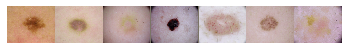

<Figure size 1440x720 with 0 Axes>

tensor([4, 3, 3, 5, 0, 1, 3])

<Figure size 432x288 with 0 Axes>

In [45]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    plt.figure(figsize=(20,10))
#     if title is not None:
#         plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.savefig('graphs/processedimages.png')


# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, classes = next(iter(dataloader['train']))

# Make a grid from batch
inputs = inputs[:7]
classes = classes[:7]
out = utils.make_grid(inputs)

imshow(out, title=classes)
classes

In [46]:
best_acc = 0
print(best_acc)

0


In [47]:
# optimizer = optim.SGD(model.fc.parameters(), lr=1.0e-3, momentum = 0.9)
# use Adam in next phase
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
model, val_loss, val_acc, train_loss, train_acc, best_acc = train_model(model, criterion, optimizer, exp_lr_scheduler)

Epoch 0/24
----------
Learning Rate 0.001



train Loss: 1.6326 Acc: 0.5291



val Loss: 1.3843 Acc: 0.7756
Best accuracy 0.7756410256410257

Epoch 1/24
----------
Learning Rate 0.001



train Loss: 1.5577 Acc: 0.6031



val Loss: 1.3674 Acc: 0.7940
Best accuracy 0.7939560439560439

Epoch 2/24
----------
Learning Rate 0.001



train Loss: 1.5117 Acc: 0.6491



val Loss: 1.3133 Acc: 0.8516
Best accuracy 0.8516483516483516

Epoch 3/24
----------
Learning Rate 0.001



train Loss: 1.4921 Acc: 0.6692



val Loss: 1.3264 Acc: 0.8397

Epoch 4/24
----------
Learning Rate 0.001



train Loss: 1.4703 Acc: 0.6919



val Loss: 1.3333 Acc: 0.8315

Epoch 5/24
----------
Learning Rate 0.001



Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
train Loss: 1.4558 Acc: 0.7068



val Loss: 1.3347 Acc: 0.8306

Epoch 6/24
----------
Learning Rate 0.0001



train Loss: 1.4137 Acc: 0.7506



val Loss: 1.3233 Acc: 0.8425

Epoch 7/24
----------
Learning Rate 0.0001



train Loss: 1.4078 Acc: 0.7568



val Loss: 1.3222 Acc: 0.8416

Epoch 8/24
----------
Learning Rate 0.0001



train Loss: 1.4030 Acc: 0.7608



val Loss: 1.3206 Acc: 0.8388

Epoch 9/24
----------
Learning Rate 0.0001



train Loss: 1.3965 Acc: 0.7679



val Loss: 1.3164 Acc: 0.8471

Epoch 10/24
----------
Learning Rate 0.0001



train Loss: 1.3962 Acc: 0.7689



val Loss: 1.3238 Acc: 0.8397

Epoch 11/24
----------
Learning Rate 0.0001



Epoch    12: reducing learning rate of group 0 to 1.0000e-05.
train Loss: 1.3905 Acc: 0.7746



val Loss: 1.3316 Acc: 0.8342

Epoch 12/24
----------
Learning Rate 1e-05



train Loss: 1.3882 Acc: 0.7769



val Loss: 1.3164 Acc: 0.8507

Epoch 13/24
----------
Learning Rate 1e-05



train Loss: 1.3861 Acc: 0.7791



val Loss: 1.3155 Acc: 0.8498

Epoch 14/24
----------
Learning Rate 1e-05



train Loss: 1.3854 Acc: 0.7799



val Loss: 1.3169 Acc: 0.8425

Epoch 15/24
----------
Learning Rate 1e-05



Epoch    16: reducing learning rate of group 0 to 1.0000e-06.
train Loss: 1.3825 Acc: 0.7835



val Loss: 1.3157 Acc: 0.8498

Epoch 16/24
----------
Learning Rate 1.0000000000000002e-06



train Loss: 1.3856 Acc: 0.7804



val Loss: 1.3181 Acc: 0.8443

Epoch 17/24
----------
Learning Rate 1.0000000000000002e-06



train Loss: 1.3842 Acc: 0.7804



val Loss: 1.3118 Acc: 0.8544
Best accuracy 0.8543956043956044

Epoch 18/24
----------
Learning Rate 1.0000000000000002e-06



train Loss: 1.3825 Acc: 0.7839



val Loss: 1.3226 Acc: 0.8407

Epoch 19/24
----------
Learning Rate 1.0000000000000002e-06



Epoch    20: reducing learning rate of group 0 to 1.0000e-07.
train Loss: 1.3828 Acc: 0.7835



val Loss: 1.3197 Acc: 0.8416

Epoch 20/24
----------
Learning Rate 1.0000000000000002e-07



train Loss: 1.3827 Acc: 0.7824



val Loss: 1.3242 Acc: 0.8407

Epoch 21/24
----------
Learning Rate 1.0000000000000002e-07



train Loss: 1.3825 Acc: 0.7836



val Loss: 1.3217 Acc: 0.8397

Epoch 22/24
----------
Learning Rate 1.0000000000000002e-07



train Loss: 1.3851 Acc: 0.7790



val Loss: 1.3188 Acc: 0.8452

Epoch 23/24
----------
Learning Rate 1.0000000000000002e-07



Epoch    24: reducing learning rate of group 0 to 1.0000e-08.
train Loss: 1.3842 Acc: 0.7806



val Loss: 1.3226 Acc: 0.8388

Epoch 24/24
----------
Learning Rate 1.0000000000000004e-08



train Loss: 1.3841 Acc: 0.7818



val Loss: 1.3180 Acc: 0.8434

Training complete in 501m 46s
Best val Acc: 0.854396


In [49]:
# state = {
#     'epochs' : 35,
#     'model state dict' : model.state_dict(),
#     'optimizer state dict' : optimizer.state_dict()
# #     'val accuracy': best_val_acc
# }
# import pickle
dirr = "D:\Github\SkinCancerCapstone\models\densenet121"
# os.makedirs(dirr)
torch.save(model, os.path.join(dirr,'densenet121-new.pth'))
# with open(os.path.join(dirr, "val_loss.pickle"), 'wb') as fp:
#     pickle.dump()


C:\ProgramData\Anaconda3\envs\pythongpu\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FCModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [79]:
# for x in val_loss:
#     total_val_loss.sppend(x)
# for x in val_acc:
#     total_val_acc.sppend(x)
# for x in train_loss:
#     total_train_loss.sppend(x)
# for x in train_acc:
#     total_train_acc
    

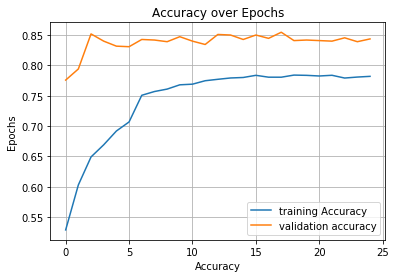

In [50]:
# fig = plt.figure(num = 2)
# fig1 = fig.add_subplot(2,1,1)
# fig2 = fig.add_subplot(2,1,2)
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.title('Accuracy over Epochs') 
plt.plot(val_acc, label = 'training Accuracy')
plt.plot(train_acc, label = 'validation accuracy')
plt.grid()
# fig2.plot(total_loss_val, label = 'validation acc')
# fig2.plot(total_loss_train, label = 'training accuracy')
plt.savefig('graphs/accuracy-densenetfcm.png')
plt.legend()
plt.show()

In [81]:
# val_acc

In [82]:
# train_acc

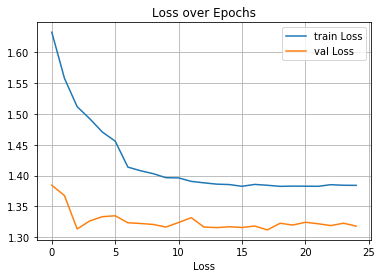

In [51]:
# fig = plt.figure(num = 2)
# fig1 = fig.add_subplot(2,1,1)
# fig2 = fig.add_subplot(2,1,2)
plt.xlabel('Loss')
plt.title('Loss over Epochs')
plt.plot(val_loss, label = 'train Loss')
plt.plot(train_loss, label = 'val Loss')
plt.grid()
# fig2.plot(total_loss_val, label = 'validation acc')
# fig2.plot(total_loss_train, label = 'training accuracy')
plt.savefig('graphs/loss-densenetfcm.png')
plt.legend()
plt.show()

In [70]:
# val_loss

In [71]:
# train_loss

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('graphs/conf_mat.png')
    plt.show()

In [53]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for images, labels in tqdm(dataloader['test']):
#         images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
# plot_confusion_matrix(confusion_mtx, plot_labels)

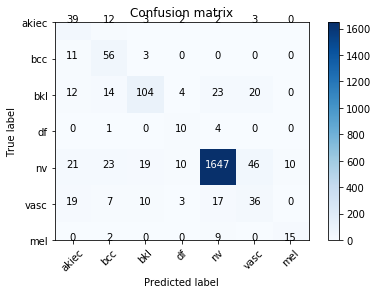

In [54]:
plot_confusion_matrix(confusion_mtx, plot_labels)

In [55]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.38      0.64      0.48        61
         bcc       0.49      0.80      0.61        70
         bkl       0.75      0.59      0.66       177
          df       0.34      0.67      0.45        15
          nv       0.97      0.93      0.95      1776
        vasc       0.34      0.39      0.37        92
         mel       0.60      0.58      0.59        26

    accuracy                           0.86      2217
   macro avg       0.55      0.66      0.59      2217
weighted avg       0.88      0.86      0.87      2217



In [67]:
from PIL import Image

def predict(path, modelpath = "D:\Github\SkinCancerCapstone\models\densenet121\densenet121-new.pth"):
    model = torch.load(modelpath)
#     model.to('cuda')
    model.eval()
    
    img = Image.open(path)
    img = test_transform(img).float()
    img = Variable(img, requires_grad=False)
    img = img.unsqueeze(0).cuda()
    output = model(img)
    print(output)
    prediction = output.max(1, keepdim=True)[1]
    print(prediction)
#     y_label.extend(labels.cpu().numpy())
#     y_predict.extend(np.squeeze(prediction.cpu().numpy().T))
#     print(y_predict)
# imsize = 224
# loader = transforms.Compose([transforms.Resize(input_size), 
#                                     transforms.ToTensor(),
#                                     transforms.Normalize(norm_mean, norm_std)])

# def image_loader(image_name):
#     """load image, returns cuda tensor"""
#     image = Image.open(image_name)
#     image = loader(image).float()
#     image = Variable(image, requires_grad=True)
#     image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
#     return image.cuda()  #assumes that you're using GPU

# image = image_loader(PATH TO IMAGE)

# your_trained_net(image)

predict("D:/Github/SkinCancerCapstone/report/img/nv.jpg")

tensor([[7.9619e-16, 1.6620e-10, 4.4542e-05, 1.4011e-08, 5.8515e-02, 1.2037e-05,
         9.4143e-01]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[6]], device='cuda:0')
